In [3]:
import pandas as pd
import numpy as np
import toml
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import sys
import os

notebook_dir = os.getcwd()
project_root = os.path.dirname(notebook_dir)
module_path = os.path.join(project_root, 'src', 'data_preprocessing')
sys.path.append(module_path)
print(f"Dodano do ścieżki: {module_path}")

from feature_engineer import FeatureEngineer

np.random.seed(14)

Dodano do ścieżki: C:\Users\Jakub\Real Estate Price Prediction\src\data_preprocessing


ModuleNotFoundError: No module named 'src'

In [ ]:
url = 'https://raw.githubusercontent.com/sztyberj/Real-Estate-Price-Prediction/refs/heads/model_training/data/cleaned/vT_2025_06_23.csv'

data = pd.read_csv(url, sep=';')

print(data.head(5))

data_shuffled = data.sample(frac=1, random_state=14).reset_index(drop=True)

n = len(data)
train_end = int(0.7 * n)
val_end = int(0.85 * n)

df_train = data_shuffled.iloc[:train_end]
df_val   = data_shuffled.iloc[train_end:val_end]
df_test  = data_shuffled.iloc[val_end:]

#train set
y_train = df_train.iloc[:, 0].to_numpy()
X_train_df = df_train.iloc[:, 1:]

#val/dev set
y_val = df_val.iloc[:, 0].to_numpy()
X_val_df = df_val.iloc[:, 1:]

#test/test set
y_test = df_test.iloc[:, 0].to_numpy()
X_test_df = df_test.iloc[:, 1:]


print(f"Train size: {X_train_df.shape[0], y_train.shape[0]}")
print(f"Val size: {X_val_df.shape[0], y_val.shape[0]}")
print(f"Test size: {X_test_df.shape[0], y_test.shape[0]}")

In [3]:
with open(r"C:\Users\Jakub\Real Estate Price Prediction\config.toml", 'r') as f:
    config = toml.load(f)

engineer = FeatureEngineer(config)
engineer.fit(X_train_df)

X_train_df = engineer.transform(X_train_df)
X_val_df = engineer.transform(X_val_df)
X_test_df = engineer.transform(X_test_df)

y_scaler = StandardScaler()

y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_val_scaled = y_scaler.transform(y_val.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1))

FeatureEngineer: Fit scaler for '['price_per_meter', 'area', 'rooms', 'floor', 'year_built', 'rent', 'building_max_floor']'.
FeatureEngineer: 'building_type' reduced for fit purposes (to learn correct OHE categories).
FeatureEngineer: Learned frequency map for 'district'.
FeatureEngineer: Learned categories for 'finish_status': ['ready_to_use', 'to_completion', 'to_renovation'].
FeatureEngineer: Learned categories for 'building_type': ['apartment', 'block', 'other', 'tenement'].
FeatureEngineer: Learned luxury threshold for 'price_per_meter': 25472.80
DataProcessor: 'elevator' feature created.
DataProcessor: 'balcony' feature created.
DataProcessor: 'garage' feature created.
DataProcessor: 'furnished' feature created.
DataProcessor: 'rooms_per_area' feature created.
FeatureEngineer: Reduced 'heating' to binary.
FeatureEngineer: Reduced 'market_type' to binary.
FeatureEngineer: Reduced 'ownership' to binary.
FeatureEngineer: 'building_type' reduced.
FeatureEngineer: 'is_luxury' feature 

In [4]:
mse_scores = []
r2_scores = []

In [5]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree Regressor': DecisionTreeRegressor(max_depth=10, min_samples_split=5, random_state=14),
    'Random Forest Regressor': RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=5, random_state=14, n_jobs=-1),
    'XGBoost Regressor': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, learning_rate=0.1, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=14, n_jobs=-1),
    'Gradient Boosting Regressor': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=14)
}

results_summary = []
trained_models = {}

In [7]:
for model_name, model_instance in models.items():
    print({model_name})
    model_instance.fit(X_train_df, y_train_scaled)
    trained_models[model_name] = model_instance

    # Validation
    y_val_pred = model_instance.predict(X_val_df)
    val_mse = mean_squared_error(y_val_scaled, y_val_pred)
    val_r2 = r2_score(y_val_scaled, y_val_pred)

    print(f"MSE Val {model_name}: {val_mse:.4f}")
    print(f"R2 Val {model_name}: {val_r2:.4f}")

    results_summary.append({
        'Model': model_name,
        'Val_MSE': val_mse,
        'Val_R2': val_r2
    })

results_df = pd.DataFrame(results_summary)
results_df = results_df.sort_values(by='Val_MSE', ascending=True) # Sortuj po MSE na zbiorze walidacyjnym
print("\n--- Summary ---")
print(results_df.to_string())

{'Linear Regression'}
MSE Val Linear Regression: 0.0761
R2 Val Linear Regression: 0.9242
{'Decision Tree Regressor'}
MSE Val Decision Tree Regressor: 0.0203
R2 Val Decision Tree Regressor: 0.9797
{'Random Forest Regressor'}
MSE Val Random Forest Regressor: 0.0065
R2 Val Random Forest Regressor: 0.9935
{'XGBoost Regressor'}
MSE Val XGBoost Regressor: 0.0065
R2 Val XGBoost Regressor: 0.9935
{'Gradient Boosting Regressor'}
MSE Val Gradient Boosting Regressor: 0.0110
R2 Val Gradient Boosting Regressor: 0.9890

--- Summary ---
                         Model  Val_MSE  Val_R2
3            XGBoost Regressor   0.0065  0.9935
2      Random Forest Regressor   0.0065  0.9935
4  Gradient Boosting Regressor   0.0110  0.9890
1      Decision Tree Regressor   0.0203  0.9797
0            Linear Regression   0.0761  0.9242



--- Final check on test set ---

Best Model: XGBoost Regressor
MSE Test XGBoost Regressor: 0.0061
R2 test XGBoost Regressor: 0.9938


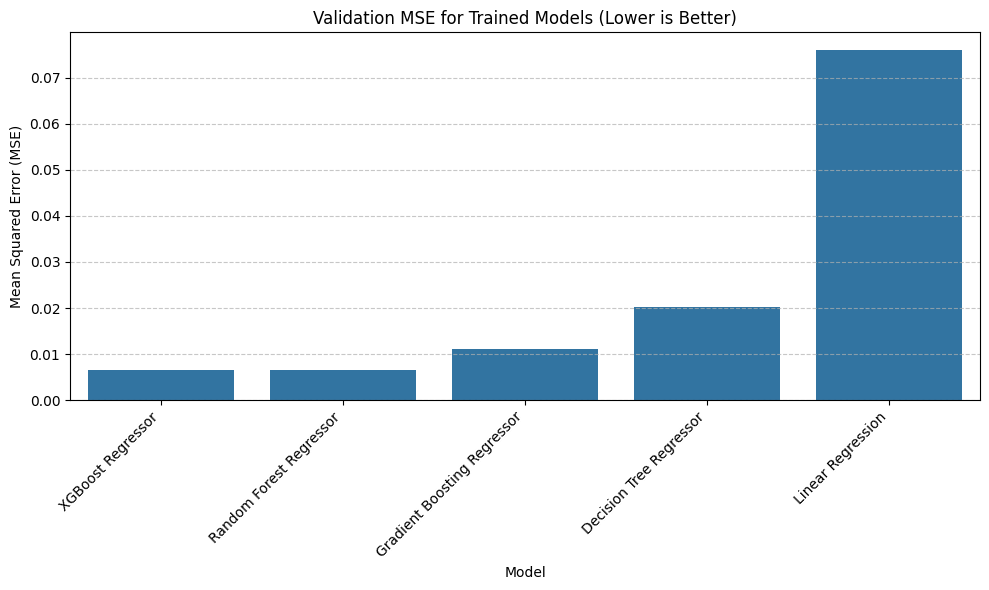

In [9]:
print("\n--- Final check on test set ---")

# Lowest Val_MSE
best_model_name_overall = results_df.iloc[0]['Model']
final_best_model = trained_models[best_model_name_overall]

print(f"\nBest Model: {best_model_name_overall}")

# Final predict
y_test_pred_final = final_best_model.predict(X_test_df)
test_mse_final = mean_squared_error(y_test_scaled, y_test_pred_final)
test_r2_final = r2_score(y_test_scaled, y_test_pred_final)

print(f"MSE Test {best_model_name_overall}: {test_mse_final:.4f}")
print(f"R2 test {best_model_name_overall}: {test_r2_final:.4f}")

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Val_MSE', data=results_df)
plt.title('Validation MSE for Trained Models (Lower is Better)')
plt.ylabel('Mean Squared Error (MSE)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()